In [1]:
import os.path
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
from tqdm import tqdm
import os
from ast import literal_eval
import matplotlib.pyplot as plt
import seaborn as sns
import toolsets.raw_data_scaffold as rds
import toolsets.T_rex as trx
import toolsets.spectra_operations as so
import toolsets.spectra_plotter as plotter
import toolsets.denoising_related_functions as drf
import re
import chemparse
from toolsets.file_io import read_df, save_df
from pubchempy import Compound, get_compounds
from toolsets.search import quick_search_values, quick_search_sorted, string_search, search_feature
import itertools
import toolsets.chem_utils as cu
from rdkit import Chem
import matplotlib.pyplot as plt
import seaborn as sns
from molmass import Formula
from rdkit.Chem.rdMolDescriptors import CalcMolFormula
master_dir = '/Users/fanzhoukong/Documents/GitHub/Libgen_data/denoising_data'
figure_dir = '/Users/fanzhoukong/Documents/GitHub/Libgen_data/denoising_data/figures'

# fetching data

In [2]:
import requests

# HILIC pos

In [3]:
master_ids = ['b2JMB7R', 'b7JWOBC', 'b3M6SD1', 'bIZGW2U']#hilic neg, hilic pos,
output_name = ['hilic_neg', 'hilic_pos', 'c18_neg', 'c18_pos']

In [4]:
data = pd.read_csv(os.path.join(master_dir, output_name[1]+'.csv'))

In [4]:
def is_denoisable(msms, ref_msms, n = 3):
    msms = so.sort_spectrum(msms)
    mass, intensity = so.break_spectra(msms)
    mass_ref, intensity_ref = so.break_spectra(ref_msms)
    if len(mass_ref)<n or len(mass)<n:
        return False
    order = np.argsort(intensity_ref)
    intensity_ref = intensity_ref[order]
    mass_ref = mass_ref[order]
    ref_key_mass = mass_ref[-n:]
    ref_key_intensity = intensity_ref[-n:]
    ref_key_mass = np.flip(ref_key_mass)
    ref_key_intensity = np.flip(ref_key_intensity)
    key_mass = np.zeros(n)
    key_intensity = np.zeros(n)
    ratios = np.zeros(n-1)
    ref_ratios = np.zeros(n-1)
    for i in range(0, n):
        idx_left, idx_right = mass.searchsorted([ref_key_mass[i]-0.01, ref_key_mass[i]+0.01+1E-9])
        if idx_right-idx_left==0:
            return( False ) #one of the key mass is not found
        anchor = np.argmax(intensity[idx_left:idx_right])
        key_mass[i]=mass[idx_left:idx_right][anchor]
        key_intensity[i]=intensity[idx_left:idx_right][anchor]
    for i in range(0, n-1):
        ratios[i]=key_intensity[i]/key_intensity[i+1]
        ref_ratios[i]=ref_key_intensity[i]/ref_key_intensity[i+1]
    cross_ratio = ref_ratios/ratios
    if np.max(np.diff(key_intensity))<0:
        return True
    else:
        return False
    # if np.max(cross_ratio)<=1*1.5 and np.min(cross_ratio)>=1/1.5:
    #     return True
    # else:
    #     return False



In [5]:
def clean_data(data_in, peak_convert = True):
    data = data_in.copy()
    data = data[~data['library_peaks'].isna()]
    if peak_convert ==True:
        peak= []
        library_peaks = []
        for index, row in data.iterrows():

            peak.append(so.sort_spectrum(so.convert_nist_to_string(literal_eval(row['peak']))))
            library_peaks.append(so.sort_spectrum(so.convert_nist_to_string(literal_eval(row['library_peaks']))))
        data['peak']=peak
        data['library_peaks']=library_peaks
    print(len(data))
    check_mark = []
    for index, row in tqdm(data.iterrows(), total = len(data)):
        check_mark.append(is_denoisable(row['peak'], row['library_peaks'], n = 2))
    data['check_mark']=check_mark
    calculated_pmz = np.zeros(len(data))
    for index, row in tqdm(data.iterrows(), total = len(data)):
        adduct = row['adduct']
        if adduct[-1]!='+':
            adduct = adduct+'+'
        try:
            calculated_pmz[index]=cu.calculate_precursormz(row['smiles'], adduct, if_smiles=True)
        except:
            calculated_pmz[index]=0
    data['calculated_pmz']=calculated_pmz
    data['pmz_offset']=abs(data['precursor_mz']-data['calculated_pmz'])
    data = data[data['pmz_offset']<=0.01]
    data=data[data['check_mark']==True]
    return(data)

In [17]:

    # data['entropy_raw']=entropy_raw
    # data['entropy_spec']=entropy_spec
    # data['entropy_dnl']=entropy_dnl
    # data['entropy_thres']=entropy_thr_1

In [212]:
# data.to_csv(os.path.join(master_dir,'hilic_pos_denoisable.csv'), index = False)

In [16]:
from toolsets.search import string_search
def denoising_search(row, mega_mona):
    pmz_candidate = quick_search_sorted(mega_mona, 'PrecursorMZ', row['precursor_mz']-0.01, row['precursor_mz']+0.01)
    charge = [cu.break_adduct(x)[2] for x in pmz_candidate['Precursor_type']]
    processed_formulas = [drf.prep_formula(x['SMILES'], x['Precursor_type']) for i, x in pmz_candidate.iterrows()]
    pmz_candidate['processed_formulas']=processed_formulas
    pmz_candidate['charge']=charge
    entropy_denoised = []
    entropy_raw = []
    msms_denoised_all = []
    msms_raw_all = []
    pmz_candidate_curated = pd.DataFrame()
    for f in pmz_candidate['processed_formulas'].unique():

        if f ==f:
            pmz_f_temp = string_search(pmz_candidate, 'processed_formulas', f)
            element_dict, element_count, element_mass, all_possible_mass, all_possible_candidate_formula = drf.get_all_subsets(f)
            msms_denoised = drf.denoising_with_subset(row['peak'], row['precursor_mz'], element_dict, all_possible_mass, all_possible_candidate_formula)
            msms_denoised_temp = [msms_denoised]*len(pmz_f_temp)
            entropy_raw_temp = [so.entropy_identity(row['peak'], m['spectrum'], row['precursor_mz']) for n,m in pmz_f_temp.iterrows()]
            entropy_denoised_temp = [so.entropy_identity(msms_denoised, m['spectrum'], row['precursor_mz']) for n,m in pmz_f_temp.iterrows()]
            msms_raw = [row['peak']]*len(pmz_f_temp)

        else:
            pmz_f_temp = pmz_candidate[pmz_candidate['processed_formulas'].isna()]
            entropy_raw_temp = [so.entropy_identity(row['peak'], m['spectrum'], row['precursor_mz']) for n,m in pmz_f_temp.iterrows()]
            msms_denoised_temp = [row['peak']]*len(pmz_f_temp)
            msms_raw = [row['peak']]*len(pmz_f_temp)
            entropy_denoised_temp = entropy_raw_temp.copy()
        entropy_raw.extend(entropy_raw_temp)
        msms_denoised_all.extend(msms_denoised_temp)
        entropy_denoised.extend(entropy_denoised_temp)
        msms_raw_all.extend(msms_raw)
        pmz_candidate_curated = pd.concat([pmz_candidate_curated, pmz_f_temp], ignore_index=True)
    pmz_candidate_curated['msms_denoised']=msms_denoised_all
    pmz_candidate_curated['msms_raw']=msms_raw_all
    pmz_candidate_curated['entropy_denoised_raw']=entropy_raw
    pmz_candidate_curated['entropy_denoised_denoised']=entropy_denoised
    return(pmz_candidate_curated)

In [3]:
from toolsets.file_io import read_df, save_df

In [2]:
result_df = read_df('/Users/fanzhoukong/Documents/GitHub/Libgen_data/denoising_data/masswiki_searched_with_recal_bd.csv')

done read in df


In [66]:
results_top_hit_raw = pd.DataFrame()
results_top_hit_denoised =pd.DataFrame()
for i in tqdm(result_df['label'].unique()):
    data_temp = string_search(result_df, 'label', i)
    data_temp.sort_values(by = 'entropy_denoised_raw', inplace = True, ascending=False)
    results_top_hit_raw = pd.concat([results_top_hit_raw, data_temp.iloc[0:1]], ignore_index=True)
    data_temp.sort_values(by = 'entropy_denoised_denoised', inplace = True, ascending=False)
    results_top_hit_denoised = pd.concat([results_top_hit_denoised, data_temp.iloc[0:1]], ignore_index=True)

100%|██████████| 1247/1247 [00:01<00:00, 634.57it/s]


In [16]:
results_temp = results_top_hit_denoised.sort_values(by = 'entropy_denoised_denoised', ascending=True)
results_temp.reset_index(inplace=True, drop = True)

100%|██████████| 1247/1247 [00:01<00:00, 666.20it/s]


In [39]:
def calculate_fdr_given_threshold(result_df, cutoff):
    fdr_raws = []
    fdr_denoise = []
    for l in result_df['label'].unique():
        cur_com = string_search(result_df, 'label', l)
        raw_p = cur_com[cur_com['entropy_denoised_raw']>=cutoff]
        raw_p.sort_values(by = 'entropy_denoised_raw', ascending=False, inplace = True)
        raw_p = raw_p.iloc[0:3]
        raw_fp = raw_p[raw_p['tag']==False]
        d_p = cur_com[cur_com['entropy_denoised_denoised']>=cutoff]
        d_p.sort_values(by = 'entropy_denoised_denoised', ascending=False, inplace = True)
        d_p=d_p.iloc[0:3]
        d_fp = d_p[d_p['tag']==False]
        if len(d_p)>0 and len(raw_p)>0:
            fdr_raws.append(len(raw_fp)/len(raw_p))

            fdr_denoise.append(len(d_fp)/len(d_p))
        else:
            fdr_raws.append(np.NAN)
            fdr_denoise.append(np.NAN)
        # raw_n = cur_com[cur_com['entropy_denoised_raw']<cutoff]
    # return fdr_raws, fdr_denoise
    return(np.nanmean(fdr_raws),np.nanmean(fdr_denoise) )

In [4]:
result_df = read_df(os.path.join(master_dir, 'masswiki_searched_with_recal_bd.csv'))

done read in df


# FDR, all hits

In [18]:
scope = np.arange(1,99)/100

In [40]:
fdr_r_all = []
fdr_d_all = []
for s in tqdm(scope):
    fdr_r, fdr_d = calculate_fdr_given_threshold(result_df, s)
    fdr_r_all.append(fdr_r)
    fdr_d_all.append(fdr_d)

100%|██████████| 98/98 [01:59<00:00,  1.22s/it]


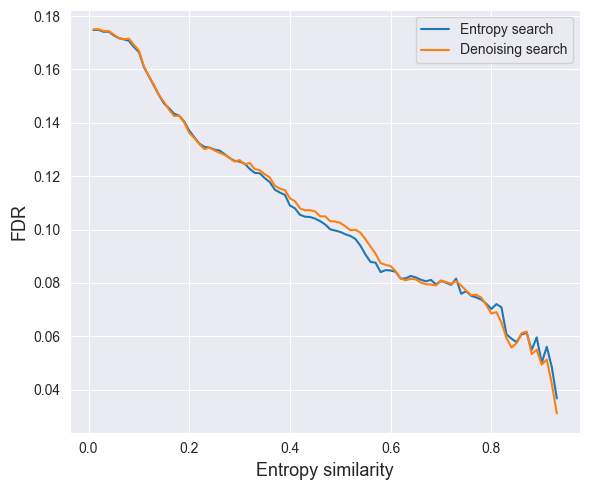

In [48]:
start = 0
end = 93
fig = plt.figure(figsize = (6, 5))#43
ax = fig.add_subplot()
sns.lineplot(x=scope[start:end], y = fdr_r_all[start:end], label = 'Entropy search')
sns.lineplot(x=scope[start:end], y = fdr_d_all[start:end], label = 'Denoising search')
# sns.lineplot(x=scope, y = fdrs_l2, label = 'denoised search l2')
plt.ylabel('FDR', size = 13)
plt.xlabel('Entropy similarity', size = 13)
# plt.xlim(0,1)
# plt.ylim(0.,0.7)

# sns.lineplot(x=scope, y = fdrs_l2, label = 'l2')
# plt.grid(True)
plt.tight_layout()
# ax.set_facecolor("white")
plt.legend()
plt.savefig('/Users/fanzhoukong/Documents/GitHub/Libgen_data/denoising_data/figures/mass_wiki_fdr_top_3_hits.png')

In [26]:
results_top_hit_raw = pd.DataFrame()
results_top_hit_denoised =pd.DataFrame()

results_top_hit_l2 = pd.DataFrame()
for i in tqdm(result_df['label'].unique()):
    data_temp = string_search(result_df, 'label', i)
    data_temp.sort_values(by = 'entropy_denoised_raw', inplace = True, ascending=False)
    results_top_hit_raw = pd.concat([results_top_hit_raw, data_temp.iloc[0:3]], ignore_index=True)
    data_temp.sort_values(by = 'entropy_denoised_denoised', inplace = True, ascending=False)
    results_top_hit_denoised = pd.concat([results_top_hit_denoised, data_temp.iloc[0:3]], ignore_index=True)

100%|██████████| 1247/1247 [00:02<00:00, 609.60it/s]


In [48]:
scope = np.arange(1,99)/100
fdr_r_all = []
fdr_d_all = []
for i in tqdm(scope):
    fdr_raw, fdr_raw_std, fdr_denoise, fdr_denoise_std = calculate_fdr_given_threshold(result_df, i)
    fdr_r_all.append(fdr_raw)
    fdr_d_all.append(fdr_denoise)

100%|██████████| 98/98 [02:09<00:00,  1.32s/it]


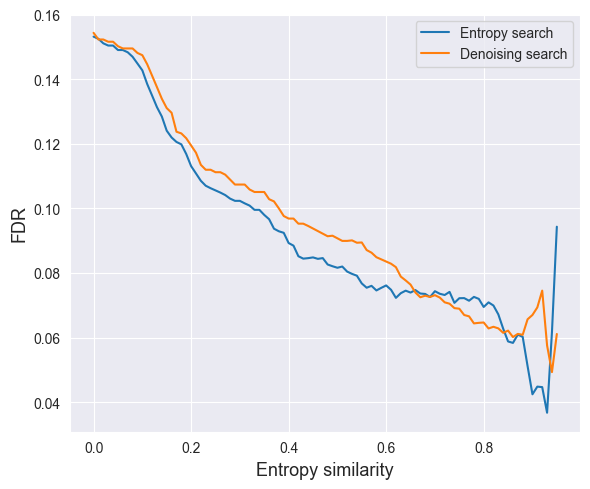

In [33]:
scope = np.arange(0,96)/100
fdrs_raw = []
fdrs_l1 = []
# fdrs_l2 = []
for i in scope:
    data_temp = results_top_hit_raw[results_top_hit_raw['entropy_denoised_raw']>i]
    fdrs_raw.append(1-(np.sum(results_top_hit_raw[results_top_hit_raw['entropy_denoised_raw']>i]['tag'])/len(results_top_hit_raw[results_top_hit_raw['entropy_denoised_raw']>i])))
    fdrs_l1.append(1-np.sum(results_top_hit_denoised[results_top_hit_denoised['entropy_denoised_denoised']>i]['tag'])/len(results_top_hit_denoised[results_top_hit_denoised['entropy_denoised_denoised']>i]))
    # fdrs_l2.append(1-np.sum(results_top_hit_l2[results_top_hit_l2['entropy_l2']>i]['tag'])/len(results_top_hit_l2[results_top_hit_l2['entropy_l2']>i]))
fig = plt.figure(figsize = (6, 5))#43
ax = fig.add_subplot()
sns.lineplot(x=scope, y = fdrs_raw, label = 'Entropy search')
sns.lineplot(x=scope, y = fdrs_l1, label = 'Denoising search')
# sns.lineplot(x=scope, y = fdrs_l2, label = 'denoised search l2')
plt.ylabel('FDR', size = 13)
plt.xlabel('Entropy similarity', size = 13)
# plt.xlim(0,1)
# plt.ylim(0.05,0.35)
# plt.savefig('/Users/fanzhoukong/Documents/GitHub/Libgen_data/denoising_data/figures/FDR.png')
# sns.lineplot(x=scope, y = fdrs_l2, label = 'l2')
# plt.grid(True)
plt.tight_layout()
# ax.set_facecolor("white")
plt.legend()
# plt.savefig(os.path.join(figure_dir, 'FDR_mass_wiki_top_hit_only.png'))